In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
from torch.nn import functional as F

from torchviz import make_dot, make_dot_from_trace 

In [2]:
DEVICE = "cpu"

In [3]:
class NAC(nn.Module):
    
    def __init__(self, parameter):
        super().__init__()
        self.no_inp = parameter.get("no_input")
        self.no_out = parameter.get("no_output")
        self.w_hat = nn.Parameter(torch.Tensor(self.no_out, self.no_inp).to(DEVICE))
        self.m_hat = nn.Parameter(torch.Tensor(self.no_out, self.no_inp).to(DEVICE))
        nn.init.xavier_normal_(self.w_hat)
        nn.init.xavier_normal_(self.m_hat)
        self.bias = None
        
    def forward(self, x):
        W = torch.tanh(self.w_hat) * torch.sigmoid(self.m_hat)
        return F.linear(x, W, self.bias)

In [4]:
class NALU(nn.Module):
    def __init__(self, parameter):
        super().__init__()
        self.f = nn.Parameter(torch.Tensor(1, 1).to(DEVICE))
        nn.init.xavier_normal_(self.f)
        self.g = nn.Parameter(torch.Tensor(1, 1).to(DEVICE))
        nn.init.xavier_normal_(self.g)
        self.h = nn.Parameter(torch.Tensor(1, 1).to(DEVICE))
        nn.init.xavier_normal_(self.h)
        self.nac = NAC(parameter)
        self.eps = 1e-12

    def forward(self, x):
        f = torch.sigmoid(self.f)
        a = self.nac(x)
        
        g = torch.sigmoid(self.g)
        m = self.nac(torch.log(torch.abs(x) + self.eps))
        m = torch.exp(m)
        
        h = torch.sigmoid(self.h)
        p = self.nac(torch.log(torch.stack((torch.log(torch.abs(x[:, 0])), x[:, 1])).T) + self.eps)
        p = torch.exp(p)
        p = torch.exp(p)
        
        y = (f*a) + (g*m) + (h*p)
        return y

In [5]:
# class PLU(nn.Module):
#     def __init__(self, parameter):
#         super().__init__()
#         self.h = nn.Parameter(torch.Tensor(1, 1).to(DEVICE))
#         nn.init.xavier_normal_(self.h)
#         self.nalu = NALU(parameter)
#         self.nac  = NAC(parameter)
#         self.eps = 1e-12

#     def forward(self, x):
#         m = self.nalu(x)
#         h = torch.sigmoid(self.h)
#         x[0, 0] = torch.log(x[0, 0])
#         x_ = 
#         p = self.nac(torch.log(torch.abs(x) + self.eps))
#         p = torch.exp(m)
#         y = (h * m) + (1 - h) * p
#         return y

In [6]:
def data_generator(min_val, max_val, num_obs, op):
    data = np.random.uniform(min_val, max_val, size=(num_obs, 2))
    if op == '+':
        targets = data[:, 0] + data[:, 1]
    elif op == '-':
        targets = data[:, 0] - data[:, 1]
    elif op == '*':
        targets = data[:, 0] * data[:, 1]
    elif op == '/':
        targets = data[:, 0] / data[:, 1]
    elif op == 'p':
        targets = np.power(data[:, 0], data[:, 1])
    elif op == 'sqrt':
        data = np.random.uniform(min_val, max_val, size=(num_obs, 1))
        targets = np.sqrt(data)
    return data, targets

In [7]:
def get_batches(x, y, data_size, batch_size):
    for id_ in range(0, data_size, batch_size):
        x_batch = x[id_:id_+batch_size]
        y_batch = y[id_:id_+batch_size]
        
        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch).float().view(-1, 1)
        
        yield x_batch, y_batch

def train(train_parameter):
    
    model      = train_parameter.get("model")
    no_epoch   = train_parameter.get("no_epoch")
    data_size  = train_parameter.get("data_size")
    min_val    = train_parameter.get("min_val")
    max_val    = train_parameter.get("max_val")
    no_epoch   = train_parameter.get("no_epoch")
    batch_size = train_parameter.get("batch_size")
    operation  = train_parameter.get("operation")
    loss       = train_parameter.get("loss")
    
    x_train, y_train = data_generator(min_val, max_val, data_size, operation)
    
    optimizer = torch.optim.Adam(model.parameters())
    
    train_error = []
    
    step = 0
    for epoch in range(no_epoch):
        model.train()
        
        for x, y in get_batches(x_train, y_train, data_size, batch_size):
            step+=1
            
            output = model(x)
            error = loss(output, y)
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            train_error.append(error.item())

            
            if step%1000==0:
                print(error.item())
            
        
    return model

In [28]:
model_parameter  = {
                    "no_input":2,
                    "no_output":1
                    }

In [29]:
ALU = NALU(model_parameter)

In [30]:
model      = ALU
min_val    = 2
max_val    = 3
data_size  = 10000
batch_size = 32
no_epoch   = 500
operation  = "p"
loss       = torch.nn.SmoothL1Loss()


train_parameter = {
                    "model":model,
                    "min_val": min_val,
                    "max_val": max_val,
                    "no_input": data_size,
                    "no_epoch": no_epoch,
                    "data_size": data_size,
                    "batch_size": batch_size,
                    "operation":operation,
                    "loss": loss
                  }

In [31]:
error = train(train_parameter)

2.710010051727295
1.720920443534851
1.3475896120071411
1.4203940629959106
0.8509520292282104
0.2796354591846466
0.18598200380802155
0.16799788177013397
0.16036784648895264
0.051559485495090485
0.016221828758716583
0.012855966575443745
0.005095021333545446
0.009688318707048893
0.003611541585996747
0.002286378527060151
0.0011319861514493823
0.0007205072324723005
0.0008036943036131561
0.0003007643099408597
0.00020248637883923948
0.00014565429592039436
0.00010818843293236569
5.703046917915344e-05
6.36969052720815e-05
3.47251225321088e-05
1.2277703717700206e-05
1.0700600796553772e-05
1.2401682397467084e-05
6.543134531966643e-06
2.909980594267836e-06
2.9880245620006463e-06
1.8976365936396178e-06
1.5945489622026798e-06
7.409159934468335e-07
6.118475539551582e-07
2.4697141043361626e-07
1.6713077855001757e-07
2.551971647335449e-07
1.0320827925625053e-07
7.186690709204413e-08
4.6677943288386814e-08
4.420363808321781e-08
2.5201224218562857e-08
1.3532115872294526e-08
8.894758707356232e-09
7.460460

KeyboardInterrupt: 

In [55]:
ques = (torch.rand([1, 2]).to(DEVICE))*4

In [56]:
# ques[0, 0] /= 100

In [57]:
ques.shape

torch.Size([1, 2])

In [58]:
ques

tensor([[3.5086, 3.2166]])

In [59]:
torch.pow(ques[0, 0], ques[0, 1]).item()

56.688621520996094

In [60]:
ALU(ques).item()

56.68699264526367

In [61]:
ALU.f

Parameter containing:
tensor([[-11.0385]], requires_grad=True)

In [62]:
ALU.g

Parameter containing:
tensor([[-9.9555]], requires_grad=True)

In [63]:
ALU.h

Parameter containing:
tensor([[10.4489]], requires_grad=True)

In [64]:
torch.sigmoid(ALU.f)

tensor([[1.6070e-05]], grad_fn=<SigmoidBackward>)

In [65]:
torch.sigmoid(ALU.g)

tensor([[4.7463e-05]], grad_fn=<SigmoidBackward>)

In [66]:
torch.sigmoid(ALU.h)

tensor([[1.0000]], grad_fn=<SigmoidBackward>)

In [20]:
ALU.nac.w_hat

Parameter containing:
tensor([[6.9907, 8.2802]], requires_grad=True)

In [21]:
ALU.nac.m_hat

Parameter containing:
tensor([[11.8041, 13.8971]], requires_grad=True)

In [22]:
torch.tanh(ALU.nac.w_hat)

tensor([[1.0000, 1.0000]], grad_fn=<TanhBackward>)

In [23]:
torch.sigmoid(ALU.nac.m_hat)

tensor([[1.0000, 1.0000]], grad_fn=<SigmoidBackward>)

In [24]:
torch.tanh(ALU.nac.w_hat) * torch.sigmoid(ALU.nac.m_hat)

tensor([[1.0000, 1.0000]], grad_fn=<MulBackward0>)

In [25]:
a = F.linear(ques, torch.tanh(ALU.nac.w_hat) * torch.sigmoid(ALU.nac.m_hat), None)

In [26]:
a

tensor([[6.7766]], grad_fn=<MmBackward>)

In [27]:
ques

tensor([[3.5704, 3.2062]])

In [29]:
ALU.g

Parameter containing:
tensor([[1.3434]], requires_grad=True)

In [30]:
torch.sigmoid(ALU.g)

tensor([[0.7931]], grad_fn=<SigmoidBackward>)

In [31]:
m = ALU.nac(torch.log(torch.abs(ques)))

In [32]:
torch.exp(m)

tensor([[11.4474]], grad_fn=<ExpBackward>)

In [33]:
ALU.h

Parameter containing:
tensor([[0.3497]], requires_grad=True)

In [35]:
ques

tensor([[6.8949, 7.3713]])

In [36]:
ques[0, 0] * ques[0, 1]

tensor(50.8247)

In [58]:
ALU.nac(torch.log(torch.abs(ques)))

tensor([[1.6727]], grad_fn=<MmBackward>)

In [43]:
ALU.f = 0
ALU.g = 0
ALU.h = 1

TypeError: cannot assign 'int' as parameter 'f' (torch.nn.Parameter or None expected)

In [45]:
ALU.f = 1000

TypeError: cannot assign 'int' as parameter 'f' (torch.nn.Parameter or None expected)

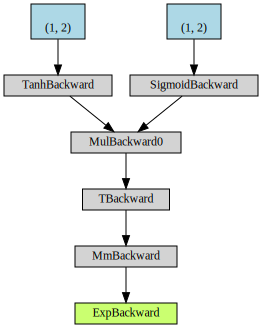

In [159]:
make_dot(ALU(ques))